In [1]:
import keras
from keras.models import Sequential
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Dropout, Activation, Lambda, Permute, Reshape
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import  BatchNormalization
from keras.layers.convolutional import *
import numpy as np
import tensorflow as tf
# import theano
import  matplotlib.pyplot as plt
from PIL import Image
import matplotlib
import itertools
from numpy import*
from sklearn.utils import shuffle
%matplotlib inline
import random as rn
import os
os.environ['PYTHONASHSEED']= '0'
import  PIL.Image

Using TensorFlow backend.


In [2]:
#setting  the  seed for nummy_gennerated random numbers
np.random.seed(10)
#seting the seed for python random numbers
#rn.seed(100)
#seting the seed for tensorflow random numbers
#tf.set_random_seed(500)

## Data Loading

In [3]:
train_path = '.\MAKEUP\Train' 
valid_path = '.\MAKEUP\Valid' 
#test_path = '.\CASIA1\Test'

train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size = (112,112), classes = ['MakeUp','Normal'], batch_size =8)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size = (112,112), classes = ['MakeUp','Normal'], batch_size = 8)
#test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size = (224,224), classes = ['Au','Sp'], batch_size =10)

Found 568 images belonging to 2 classes.
Found 190 images belonging to 2 classes.


In [4]:
def plots(ims, figsize = (12,6), rows=1, interp =False , titles = None):
    if  type(ims[0]) is  np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] !=3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize = figsize) 
    cols = len(ims)// rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows,cols,i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation = None if interp else 'none')
        plt.show()

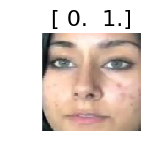

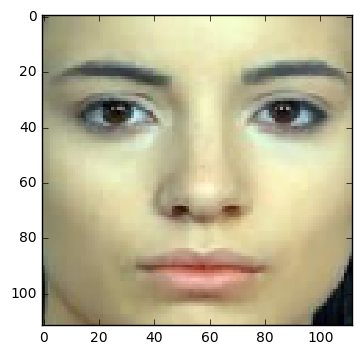

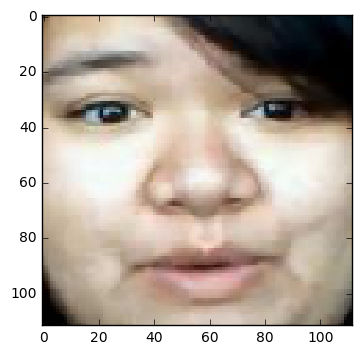

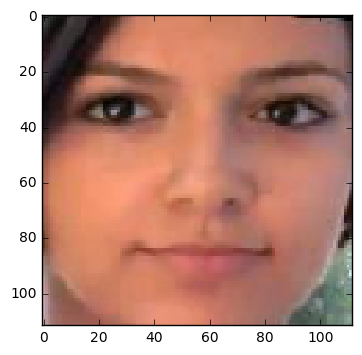

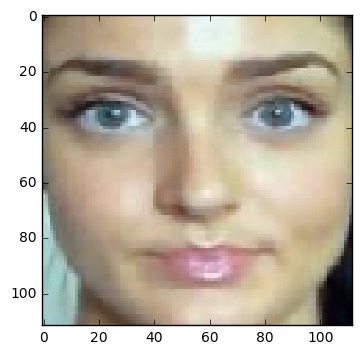

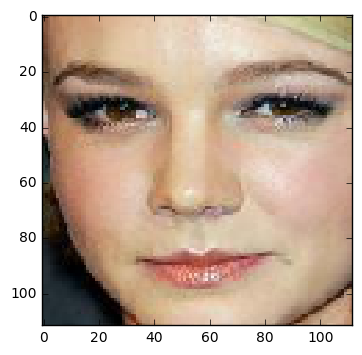

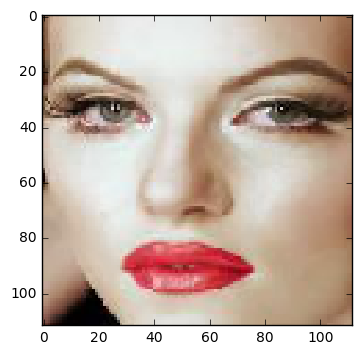

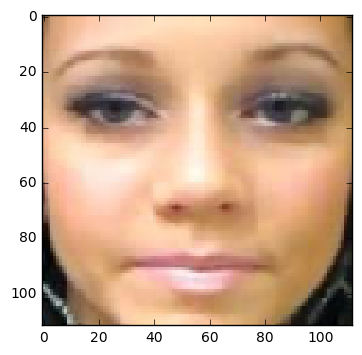

In [5]:

imgs, labels = next(train_batches)
plots(imgs, titles = labels)

## AlexNet Architecture 

### Model Parameters 

In [6]:
from keras import regularizers
N_CATEGORY = 2 


DROPOUT = 0.5
model_input = Input(shape = (112, 112, 3))

# First convolutional Layer (96x11x11)
z = Conv2D(filters = 96, kernel_size = (11,11), strides = (4,4), activation = "relu")(model_input)
z = MaxPooling2D(pool_size = (3,3), strides=(2,2))(z)
z = BatchNormalization()(z)

# Second convolutional Layer (256x5x5)
z = ZeroPadding2D(padding = (2,2))(z)
z = Convolution2D(filters = 256, kernel_size = (5,5), strides = (1,1), activation = "relu")(z)
z = MaxPooling2D(pool_size = (3,3), strides=(2,2))(z)
z = BatchNormalization()(z)

# Rest 3 convolutional layers
z = ZeroPadding2D(padding = (1,1))(z)
z = Convolution2D(filters = 384, kernel_size = (3,3), strides = (1,1), activation = "relu")(z)

z = ZeroPadding2D(padding = (1,1))(z)
z = Convolution2D(filters = 384, kernel_size = (3,3), strides = (1,1), activation = "relu")(z)

z = ZeroPadding2D(padding = (1,1))(z)
z = Convolution2D(filters = 256, kernel_size = (3,3), strides = (1,1), activation = "relu")(z)

z = MaxPooling2D(pool_size = (3,3), strides=(2,2))(z)
z = Flatten()(z)

z = Dense(4096, activation="relu")(z)
z = Dropout(DROPOUT)(z)

z = Dense(4096, activation="relu")(z)
z = Dropout(DROPOUT)(z)

# final_dim = 1 if N_CATEGORY == 2 else N_CATEGORY
# final_act = "sigmoid" if N_CATEGORY == 2 else "softmax"
# model_output = Dense(final_dim, activation=final_act)(z)
model_output = Dense(N_CATEGORY, activation = 'linear',kernel_regularizer=regularizers.l2(0.001))(z)

model = Model(model_input, model_output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 112, 112, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 96)        34944     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 96)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 12, 96)        384       
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 16, 16, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 256)       614656    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 256)         0         
__________

In [7]:
for layer in model.layers:
    layer.trainable = True

In [8]:
# n = len(model.layers)
# for idx, layer in enumerate(model.layers):
#     if idx < (n-1): 
#            layer.trainable = False 
#     else:
#            layer.trainable = True   

In [9]:
for layer in model.layers:
    layer.trainable = True
    
# opt = Adam(lr=0.001, decay=10e-6)
# model.compile(loss='hinge', optimizer=opt, metrics=['accuracy']) 


##### compile with SGD
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='hinge', optimizer=sgd, metrics=['accuracy'])

In [10]:
### training    
from keras.callbacks import ModelCheckpoint
# Save check point
filepath = "MyAlexNet.weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose =1, save_best_only = True, mode ='max')
callbacks_list= [checkpoint]
 # Fit the model
# model.fit(X,Y, validation_split=0.33, nb_epoch =150, batch_size =10, callbacks = callbacks_list, verbose =0)

history = model.fit_generator(train_batches, steps_per_epoch = 71, validation_data = valid_batches, validation_steps=26, epochs =200, shuffle=True, callbacks = callbacks_list, verbose =2)

Epoch 1/200
 - 5s - loss: 0.5259 - acc: 0.5246 - val_loss: 0.5040 - val_acc: 0.5534

Epoch 00001: val_acc improved from -inf to 0.55340, saving model to MyAlexNet.weights.best.hdf5
Epoch 2/200
 - 2s - loss: 0.5040 - acc: 0.4894 - val_loss: 0.5040 - val_acc: 0.5485

Epoch 00002: val_acc did not improve
Epoch 3/200
 - 2s - loss: 0.5040 - acc: 0.5352 - val_loss: 0.5040 - val_acc: 0.5680

Epoch 00003: val_acc improved from 0.55340 to 0.56796, saving model to MyAlexNet.weights.best.hdf5
Epoch 4/200
 - 2s - loss: 0.5040 - acc: 0.5370 - val_loss: 0.5040 - val_acc: 0.5631

Epoch 00004: val_acc did not improve
Epoch 5/200
 - 2s - loss: 0.5040 - acc: 0.5018 - val_loss: 0.5040 - val_acc: 0.5680

Epoch 00005: val_acc improved from 0.56796 to 0.56796, saving model to MyAlexNet.weights.best.hdf5
Epoch 6/200
 - 2s - loss: 0.5040 - acc: 0.5387 - val_loss: 0.5040 - val_acc: 0.5583

Epoch 00006: val_acc did not improve
Epoch 7/200
 - 2s - loss: 0.5040 - acc: 0.5106 - val_loss: 0.5040 - val_acc: 0.5631

